In [96]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import scipy
import math

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util
import ip_routines as ip

import imutils

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Paths defined in paths module:
 paths.data_root: /Users/trafferty/data
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.images_root: /Users/trafferty/data/images
 paths.projects_root: /Users/trafferty/data/projects
 paths.results_root: /Users/trafferty/data/results
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.dat_root: /Users/trafferty/data/dat
 paths.tmp_dir: /Users/trafferty/tmp
 paths.ws_dir: /Users/trafferty/workspace
 paths.mii_home: /Users/trafferty/dev
 paths.inhouse: /Users/trafferty/dev/src/inhouse


Rows: 140, Cols: 140


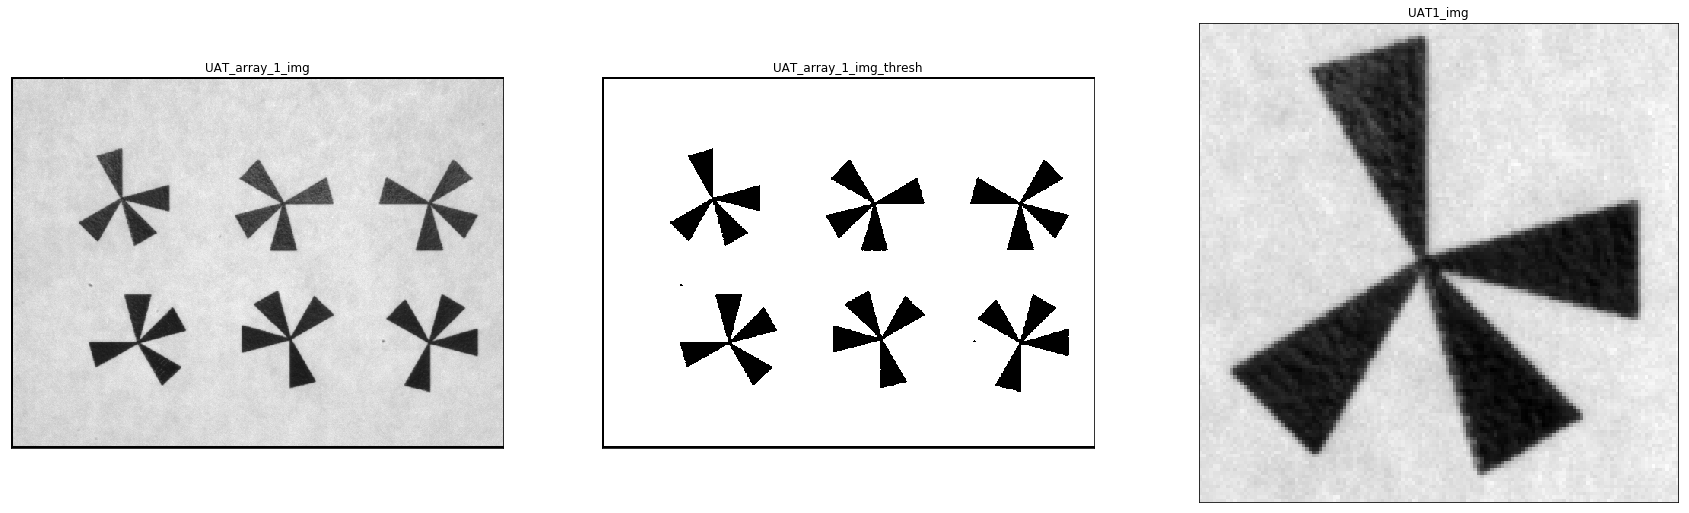

In [115]:
UAT_array_1_img = cv2.imread(paths.images_root+'/UAT_array_01.png', cv2.IMREAD_GRAYSCALE)
UAT_array_2_img = cv2.imread(paths.images_root+'/UAT_array_02.png', cv2.IMREAD_GRAYSCALE)

UAT_array_1_img_thresh = ip.faster_bradley_threshold(UAT_array_1_img, threshold=75, window_r=25)

UAT1_img = UAT_array_1_img_thresh[90:230, 80:220] #np slice: [startY:endY, startX:endX]
UAT1_img = UAT_array_1_img[90:230, 80:220] #np slice: [startY:endY, startX:endX]

rows, cols = UAT1_img.shape
print(f"Rows: {rows}, Cols: {cols}")
midX, midY = int(cols/2), int(rows/2)
l = int(min([rows,cols]) * 0.2)
# cv2.line(UAT1_img, (midX, midY-l), (midX, midY+l), util.green, 1)
# cv2.line(UAT1_img, (midX-l, midY), (midX+l, midY), util.green, 1)

util.plot_imgs([(UAT_array_1_img,'UAT_array_1_img'), (UAT_array_1_img_thresh,'UAT_array_1_img_thresh'), (UAT1_img,'UAT1_img')], max_cols = 3)

### Find Harris Corners

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


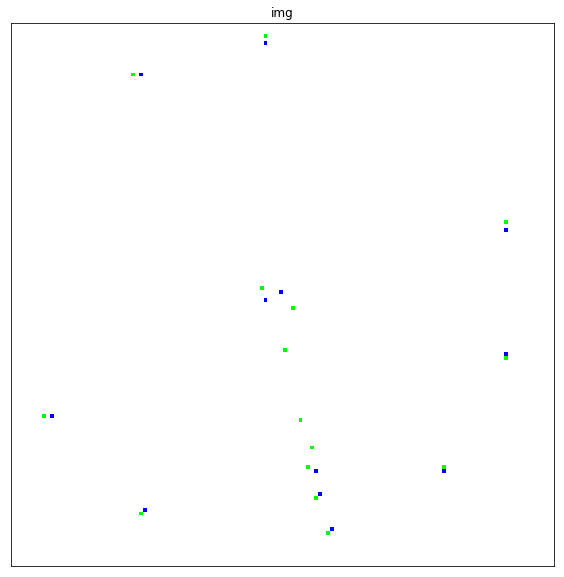

In [116]:
img = cv2.cvtColor(UAT1_img,cv2.COLOR_GRAY2BGR)

# find Harris corners
gray = np.float32(UAT1_img)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

util.plot_imgs([(img,'img')], max_cols = 3)

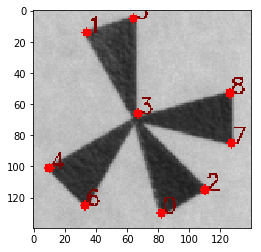

In [122]:
img = cv2.cvtColor(UAT1_img,cv2.COLOR_GRAY2BGR)

corners = cv2.goodFeaturesToTrack(UAT1_img,25,0.01,10)
corners = np.int0(corners[:9])

for idx, i in enumerate(corners):
    x,y = i.ravel()
    cv2.putText(img, str(idx), (x,y), cv2.FONT_HERSHEY_DUPLEX, 0.5, util.navy, 1)
    cv2.circle(img,(x,y),3,255,-1)

plt.imshow(img)
plt.show()

[[240 295]
 [280 100]
 [200 100]]
[[240 295]
 [ 84 418]
 [145 470]]


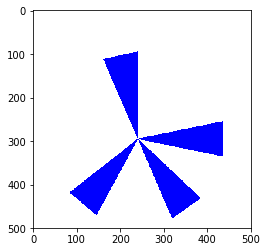

In [111]:
image = np.ones((500, 500, 3), np.uint8) * 255

# pt1 = (150, 100)
# pt2 = (100, 200)
# pt3 = (200, 200)
pt3 = (200, 100)
pt2 = (280, 100)
pt1 = (240, 295)

triangle_cnt = np.array( [pt1, pt2, pt3] )
print(triangle_cnt)

#t2 = ndimage.rotate(triangle_cnt, 10, axes=(0,1), reshape=False)
t2 = Rotate2D(triangle_cnt, scipy.array([pt1]), math.radians(220)).astype(int)
#t2 = t2.astype(int)
print(t2)

angs = [math.radians(-23.184/2), math.radians(90), math.radians(145), math.radians(220)]

for ang in angs:
    t = Rotate2D(triangle_cnt, scipy.array([pt1]), ang).astype(int)
    cv2.drawContours(image, [t], 0, (0,0,255), -1)

# cv2.drawContours(image, [triangle_cnt], 0, (0,0,255), -1)
# cv2.drawContours(image, [t2], 0, (0,255,0), -1)

plt.imshow(image)
plt.show()

In [85]:
def Rotate2D(pts, cnt, ang=scipy.pi/4):
    '''pts = {} Rotates points(nx2) about center cnt(2) by angle ang(1) in radian'''
    return scipy.dot(pts-cnt, scipy.array([[scipy.cos(ang), scipy.sin(ang)],[-scipy.sin(ang),scipy.cos(ang)]]))+cnt
